In [41]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

print("Path to dataset files:", path)


Path to dataset files: /root/.cache/kagglehub/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews/versions/1


In [42]:
import pandas as pd
import numpy as np

data = pd.read_csv(path + "/IMDB Dataset.csv")
data.head()


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [43]:
!pip install tensorflow
!pip install contractions

In [44]:
from matplotlib import pyplot as plt
import seaborn as sns
import string
import re
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk.corpus import stopwords
import contractions
import spacy

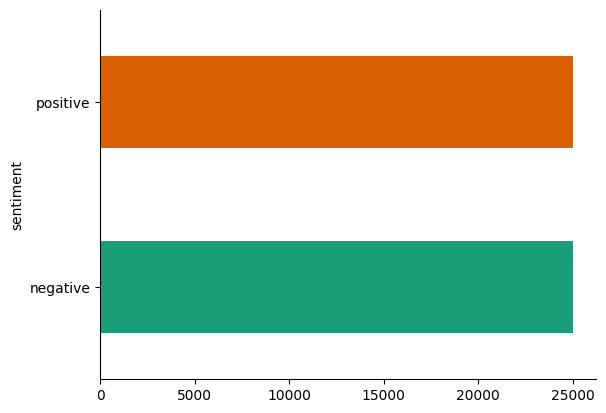

In [45]:
data.groupby('sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)


In [46]:
dup = data.duplicated().sum()
null = data.isna().sum()
print('Null Value:', null)
print('\n')
print('Duplicate Value:', dup)


Null Value: review       0
sentiment    0
dtype: int64


Duplicate Value: 418


In [47]:
data = data.drop_duplicates()
data = data.reset_index(drop=True)

In [48]:
nltk.download('stopwords')
nltk.download('wordnet')
nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words('english'))

class Preprocessing:

    @staticmethod
    def remove_html_tags(text):
        "Removes HTML tags from text"
        soup = BeautifulSoup(text, "html.parser")
        return soup.get_text()

    @staticmethod
    def remove_punctuation(text):
        "Removes punctuation from text"
        return text.translate(str.maketrans('', '', string.punctuation))

    @staticmethod
    def remove_stop_words(text):
        "Removes stop words from text"
        return ' '.join(word for word in text.split() if word.lower() not in stop_words)

    @staticmethod
    def remove_emoji(text):
        "Removes emojis from text"
        emoji_pattern = re.compile(
            "["
            u"\U0001F600-\U0001F64F"
            u"\U0001F300-\U0001F5FF"
            u"\U0001F680-\U0001F6FF"
            u"\U0001F1E0-\U0001F1FF"
            "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', text)

    @staticmethod
    def expand_contractions(text):
        "Expands contractions in text"
        return contractions.fix(text)

    @staticmethod
    def lemmatize_text(text):
        "Lemmatizes text using spaCy"
        doc = nlp(text)
        return ' '.join(token.lemma_ for token in doc if token.lemma_ != '-PRON-')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/usr/local/lib/python3.11/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [49]:
def preprocess_text(text):
    text = Preprocessing.remove_html_tags(text)
    text = Preprocessing.remove_punctuation(text)
    text = Preprocessing.remove_stop_words(text)
    text = Preprocessing.remove_emoji(text)
    text = Preprocessing.expand_contractions(text)
    text = Preprocessing.lemmatize_text(text)
    return text

data['processed_review'] = data['review'].apply(preprocess_text)


<ipython-input-48-aead92ea4f25>:11: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [50]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['processed_review'])

sequences = tokenizer.texts_to_sequences(data['review'])

data['processed_review'] = data['processed_review'].apply(lambda x: ' '.join(tokenizer.sequences_to_texts(tokenizer.texts_to_sequences([x]))))

data['processed_review'] = [tokenizer.sequences_to_texts([seq])[0].split() for seq in sequences]

data['sentiment'] = data['sentiment'].replace('positive', 1)
data['sentiment'] = data['sentiment'].replace('negative', 0)


<ipython-input-50-2282a158e4c2>:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['sentiment'] = data['sentiment'].replace('negative', 0)


In [51]:
from sklearn.model_selection import train_test_split

x = data['processed_review']
y = data['sentiment']

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.3, random_state = 42)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

x_train_sequences = tokenizer.texts_to_sequences(x_train)
x_test_sequences = tokenizer.texts_to_sequences(x_test)

max_length = max(max(len(seq) for seq in x_train_sequences), max(len(seq) for seq in x_test_sequences))

x_train_padded = pad_sequences(x_train_sequences, maxlen=max_length)
x_test_padded = pad_sequences(x_test_sequences, maxlen=max_length)


In [52]:
print("Shape of x_train_tfidf:", x_train_padded.shape)
print("Shape of x_test_tfidf:", x_test_padded.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)


Shape of x_train_tfidf: (34707, 2177)
Shape of x_test_tfidf: (14875, 2177)
Shape of y_train: (34707,)
Shape of y_test: (14875,)


In [68]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping


In [54]:
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)


In [63]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2025-01-29 19:20:47--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-01-29 19:20:47--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-01-29 19:20:48--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [65]:
def load_glove_embeddings(filepath, word_index, embedding_dim=100):
    embeddings_index = {}
    with open(filepath, encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = vector

    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

embedding_dim = 100
glove_path = "glove.6B.100d.txt"
embedding_matrix = load_glove_embeddings(glove_path, tokenizer.word_index, embedding_dim)


In [66]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_length,
                    trainable=False))  # Use pre-trained embeddings

# First LSTM Layer
model.add(Bidirectional(LSTM(32, return_sequences=True, kernel_regularizer=l2(0.001))))
model.add(Dropout(0.5))
model.add(BatchNormalization())

# Second LSTM Layer
model.add(Bidirectional(LSTM(16, return_sequences=False, kernel_regularizer=l2(0.001))))
model.add(Dropout(0.5))
model.add(BatchNormalization())

# Fully Connected Layer
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [69]:
# Train the model
history = model.fit(x_train_padded, y_train,
                    epochs=30,
                    batch_size=32,
                    validation_data=(x_test_padded, y_test),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])

Epoch 1/30
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 330s 304ms/step - accuracy: 0.5173 - loss: 1.1227 - val_accuracy: 0.6624 - val_loss: 0.8698
Epoch 2/30
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 330s 304ms/step - accuracy: 0.6505 - loss: 0.8235 - val_accuracy: 0.8036 - val_loss: 0.5889
Epoch 3/30
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 330s 304ms/step - accuracy: 0.7838 - loss: 0.6249 - val_accuracy: 0.8134 - val_loss: 0.5172
Epoch 4/30
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 330s 304ms/step - accuracy: 0.8149 - loss: 0.5330 - val_accuracy: 0.7607 - val_loss: 0.6269
Epoch 5/30
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 330s 304ms/step - accuracy: 0.8278 - loss: 0.4909 - val_accuracy: 0.8544 - val_loss: 0.4168
Epoch 6/30
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 330s 304ms/step - accuracy: 0.8447 - loss: 0.4401 - val_accuracy: 0.8491 - val_loss: 0.4001
Epoch 7/30
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 330s 304ms/step - accuracy: 0.8498 - loss: 0.4182 - val_accuracy: 0.8401 - val_loss: 0.4208
Epoch 8/30
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 330s 304ms/step - ac

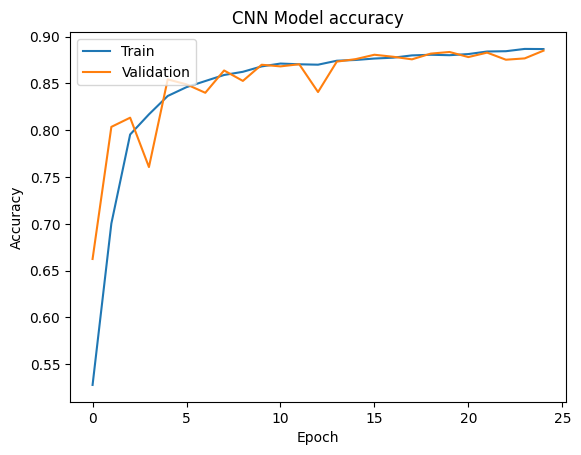

In [70]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CNN Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

465/465 ━━━━━━━━━━━━━━━━━━━━ 56s 120ms/step


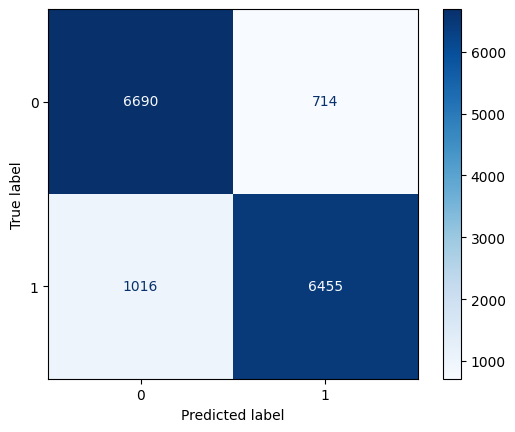

In [72]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

pred = model.predict(x_test_padded)

pred = (pred > 0.5).astype('int')

lstm_report = classification_report(y_test, pred, output_dict=True)
lstm_report = pd.DataFrame(lstm_report).transpose()

cm_lstm = confusion_matrix(y_test.argmax(axis=1), pred.argmax(axis=1))

disp = ConfusionMatrixDisplay(confusion_matrix=cm_lstm, display_labels=[0, 1])

disp.plot(cmap=plt.cm.Blues)
plt.show()

In [73]:
lstm_report

,precision,recall,f1-score,support
0,0.868155,0.903566,0.885506,7404.0
1,0.900405,0.864007,0.881831,7471.0
micro avg,0.883697,0.883697,0.883697,14875.0
macro avg,0.884280,0.883787,0.883668,14875.0
weighted avg,0.884352,0.883697,0.883660,14875.0
samples avg,0.883697,0.883697,0.883697,14875.0


### After training and testing with new method and utilize pretrain glove data from stanford, the model perform well and does not contain any overfitting. This conclude my final model for sentiment analysis!

# **End of Project!**